### 2. Clustering Task:


The dataset categories are too sparse. Create a model to group all reviews into 4-6 “meta” categories.  Here’s a suggestion, but you can choose any categories after analyzing your dataset in depth:
- Ebook readers
- Batteries 
- Accessories (keyboards, laptop stand, …)
- Non-electronics (nespresso pods, pet carrier…)

In [51]:
#For transformer model
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
from dotenv import load_dotenv
from huggingface_hub import login 
#For LDA model
import os
import nltk
from nltk.corpus import stopwords

!pip install gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 80.2 MB/s eta 0:00:00:00:0100:01


In [52]:
 # Or use your method of authentication

# Load environment variables from the .env file
load_dotenv()

# Access the Hugging Face token
hf_token = os.getenv("HF_TOKEN")

# Use the token to authenticate with Hugging Face
login(token=hf_token)

In [53]:
project_path = 'dataset/original/1429_1.csv'

In [54]:
df = pd.read_csv(project_path)

/tmp/ipykernel_109/905003903.py:1: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(project_path)


In [55]:
product_names = df.categories.value_counts().keys().to_list()

## Kmeans approach:

In [56]:
import torch
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Load pre-trained transformer model and tokenizer (example: 'distilbert-base-uncased')
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [57]:
# Function to generate embeddings from product names
def get_embeddings(texts):
    embeddings = []
    for text in texts:
        # Tokenize the text
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        
        # Get embeddings from the model
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Average the token embeddings to get a single embedding for the sentence
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy())
    
    return np.array(embeddings)

In [58]:
# Get embeddings for all product names
embeddings = get_embeddings(product_names)

# Create embeddings DataFrame
embeddings_df = pd.DataFrame(embeddings, index=product_names)

# Clustering with KMeans
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings_df)

# Create a DataFrame to show product names and their corresponding clusters
df_results = pd.DataFrame({'Product Name': product_names, 'Cluster': clusters})

# Display the clustering results
print(df_results.sort_values('Cluster').head())

                                         Product Name  Cluster
35  Electronics,eBook Readers & Accessories,Covers...        0
32  Kindle E-readers,Electronics Features,Computer...        0
25  Electronics,Amazon Device Accessories,Kindle S...        0
24  Cases,Kindle Store,Amazon Device Accessories,A...        0
23  Computers/Tablets & Networking,Tablet & eBook ...        0


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


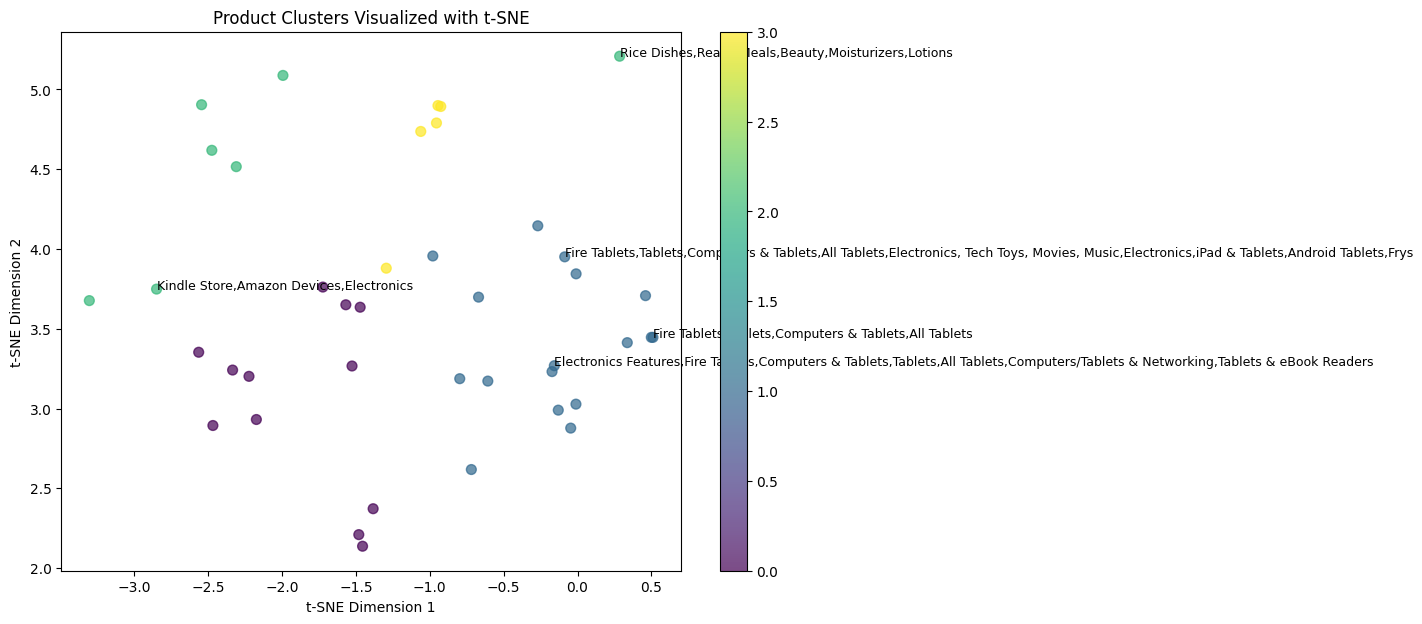

In [59]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Reduce the dimensionality of the embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_df)

# Create a scatter plot of the clusters in 2D space
plt.figure(figsize=(10, 7))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.7)
plt.colorbar()
plt.title("Product Clusters Visualized with t-SNE")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Add labels to some points for better understanding
for i in range(len(df_results)):
    if i % 10 == 0:  # Label every 10th point to avoid overcrowding
        plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], df_results['Product Name'].iloc[i], fontsize=9)

plt.show()

#visual inspecition shows that there are many categories mixed together. Therefore, a second approach was started relying on Topic Modeling / LDA

## LDA aproach

In [60]:
import os
import glob
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')


# Sample processed documents (you can replace this with your actual list of documents)
documents = product_names

# 1. Tokenize and preprocess the documents
stop_words = set(stopwords.words('english'))
punctuation_table = str.maketrans('', '', string.punctuation)

def preprocess(doc):
    tokens = word_tokenize(doc)  # Convert to lower case and tokenize
    tokens = [word.translate(punctuation_table) for word in tokens]  # Remove punctuation
    tokens = [word for word in tokens if word.isalpha()]  # Remove non-alphabetical tokens
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens

processed_docs = [preprocess(doc) for doc in documents]

# 2. Create a dictionary representation of the documents
dictionary = Dictionary(processed_docs)

# 3. Create a Bag of Words corpus
#corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [61]:
# Download necessary resources
nltk.download('punkt')  # Download the Punkt tokenizer
nltk.download('stopwords') 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [64]:
import os
import glob
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk

# Sample processed documents (you can replace this with your actual list of documents)
documents = product_names

# 1. Tokenize and preprocess the documents
stop_words = set(stopwords.words('english'))
punctuation_table = str.maketrans('', '', string.punctuation)

def preprocess(doc):
    tokens = word_tokenize(doc.lower())  # Convert to lower case and tokenize
    tokens = [word.translate(punctuation_table) for word in tokens]  # Remove punctuation
    tokens = [word for word in tokens if word.isalpha()]  # Remove non-alphabetical tokens
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens

processed_docs = [preprocess(doc) for doc in documents]

# 2. Create a dictionary representation of the documents
dictionary = Dictionary(processed_docs)

# 3. Create a Bag of Words corpus
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Function to train LDA and evaluate
def train_and_evaluate_lda(corpus, dictionary, processed_docs, num_topics=5, passes=30, alpha=0.001, random_state=None):
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, alpha=alpha, random_state=random_state)
    
    # Calculate Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    
    # Calculate Perplexity
    perplexity = lda_model.log_perplexity(corpus)
    
    return lda_model, coherence_score, perplexity

# Now you can proceed with your original code for iterating over different random states
best_model = None
best_score = {
    'iteration': None,
    'combined_score': -float('inf'),  # Starting score is very low
    'coherence': -1,   # Start with a very low coherence
    'perplexity': float('inf')  # Start with a very high perplexity
}

# Dictionary to store results for each iteration
model_scores = {}

for i in range(100):  # Or 1000 iterations
    random_state = i
    lda_model, coherence_score, perplexity = train_and_evaluate_lda(corpus, dictionary, processed_docs, random_state=random_state)
    
    # Track each model's performance
    combined_score = 0.7 * coherence_score + 0.3 * (1 / perplexity)  # Higher coherence, lower perplexity is better
    
    model_scores[i] = {'coherence': coherence_score, 'perplexity': perplexity, 'combined_score': combined_score}
    # Check if this model is the best based on combined score
    if combined_score > best_score['combined_score']:
        # Delete all other models in the folder
        best_score['iteration'] = i
        best_score['combined_score'] = combined_score
        best_score['coherence'] = coherence_score
        best_score['perplexity'] = perplexity
        best_model = lda_model
        lda_model.save(f"models/lda_models/best_lda_model_{i}.model")

# Print the best results
print(f"Best Model Iteration: {best_score['iteration']}")
print(f"Best Coherence Score: {best_score['coherence']}")
print(f"Best Perplexity: {best_score['perplexity']}")
print(f"Best Combined Score: {best_score['combined_score']}")

# Optionally: print or save model_scores dictionary for all iterations
print(model_scores)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Best Model Iteration: 45
Best Coherence Score: 0.7102527812286298
Best Perplexity: -4.263152168568183
Best Combined Score: 0.42680648196979565
{0: {'coherence': 0.5559848556680714, 'perplexity': -4.039946026021239, 'combined_score': 0.3149309811403562}, 1: {'coherence': 0.5500262600030434, 'perplexity': -4.114162987233798, 'combined_score': 0.3120995402034713}, 2: {'coherence': 0.5385715206808392, 'perplexity': -4.14203781632148, 'combined_score': 0.3045719473749362}, 3: {'coherence': 0.5552141081648377, 'perplexity': -4.236791356767392, 'combined_score': 0.31784157416406916}, 4: {'coherence': 0.6670574950925691, 'perplexity': -4.087160567777792, 'combined_score': 0.3935396558551675}, 5: {'coherence': 0.4837904829897221, 'perplexity': -4.01822932362793, 'combined_score': 0.2639935872826801}, 6: {'coherence': 0.5890998645689387, 'perplexity': -4.107773738588908, 'combined_score': 0.33933764512468856}, 7: {'coherence': 0.6328447550888142, 'perplexity': -4.106377509270571, 'combined_score

In [65]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
lda_model = LdaModel.load(f"models/lda_models/best_lda_model_{best_score['iteration']}.model")

# Prepare the visualization data
lda_display = gensimvis.prepare(lda_model, corpus, dictionary)
# Save the visualization to an HTML file
pyLDAvis.save_html(lda_display, 'flask_project/templates/lda_visualization.html')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [66]:
import csv

# 1. Get the first term from each topic and use them as labels
topic_labels = {}
for idx, topic in lda_model.show_topics(num_topics=4, num_words=1, formatted=False):
    # Get the top term for each topic
    first_term = topic[0][0]
    topic_labels[idx] = first_term

# 2. Prepare the data for export
output_data = []

for i, doc in enumerate(corpus):
    # Get the dominant topic for each document
    topic_distribution = lda_model.get_document_topics(doc)
    dominant_topic = max(topic_distribution, key=lambda x: x[1])[0]  # Get the topic with the highest probability
    
    # Get the label for the dominant topic (first term only)
    label = topic_labels.get(dominant_topic, f"Topic {dominant_topic}")
    
    # Append the original document (product names), dominant topic, and the label to the output data
    output_data.append([product_names[i], dominant_topic, label])

# 3. Export the data to a CSV file
csv_filename = 'dataset/interim/amazon_review_categories.csv'
with open(csv_filename, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['category', 'dominant_topic', 'label'])  # CSV header
    writer.writerows(output_data)

print(f"Document-topic data exported to {csv_filename}")

Document-topic data exported to dataset/interim/amazon_review_categories.csv
